This notebook takes the features classified as targets from the notebook "classify all features extracted from all the runs", finds experiment-wide means and standard deviations, 

In [2]:
import pandas as pd
import numpy as np
import sys
import pickle
import glob
import os
import matplotlib.pyplot as plt

In [3]:
EXPERIMENT_DIR = '/home/ubuntu/experiments/dwm-test'

In [4]:
# produced by the notebook "classify all features extracted from all the runs"
TEMP_DIR = '/home/ubuntu'
SEQUENCES_WITH_SPECIES_FILE_NAME = '{}/sequences-with-species-df.pkl'.format(TEMP_DIR)


In [5]:
MAPPING_FILE_NAME = "{}/recalibrated-percolator-output/percolator-idx-mapping.csv".format(EXPERIMENT_DIR)

# determine the mapping between the percolator index and the run file name
def get_percolator_run_mapping(mapping_file_name):
    df = pd.read_csv(mapping_file_name)
    mapping_l = [tuple(r) for r in df.to_numpy()]
    return mapping_l

def file_idx_for_run(run_name):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[1] == run_name:
            result = m[0]
            break
    return result

def run_name_for_file_idx(file_idx):
    result = None
    mapping_l = get_percolator_run_mapping(MAPPING_FILE_NAME)
    for m in mapping_l:
        if m[0] == file_idx:
            result = m[1]
            break
    return result

In [6]:
sequences_df = pd.read_pickle(SEQUENCES_WITH_SPECIES_FILE_NAME)

In [7]:
sequences_df['log_intensity'] = np.log2(sequences_df.intensity)

#### use this sample of e.coli sequences that occur in a majority of the runs to analyse the intensity consistency

In [8]:
sequences_df[(sequences_df.number_of_runs_identified > 15) & (sequences_df.human == False)][['sequence','charge','intensity','file_idx']].sample(10).sort_values(by=['intensity','sequence','charge'], ascending=False, inplace=False)


,sequence,charge,intensity,file_idx
98181,EAVDTTSQPVATEK,2,2772,3
17043,AGPLAGYPVVDMGIR,2,1901,16
300771,LLINGELVSGEGEK,2,1409,13
443659,SPAGAIQFEAVDAPEIIPDPFDPSKK,3,973,12
563981,YSDNGSTLSAVNFPEVSLPLHGGR,3,953,19
340614,MLLPDTVGTGGDSHTR,3,782,4
26010,ALNVEEQSVQETEQEER,2,703,16
398028,Q[-17.0265]AEDESDREVEGGR,2,648,0
184086,GIPVFNAPFSNTR,2,397,3
425097,SDFAQMLDAHANFLR,2,212,3


#### analyse a selected sequence across the experiment for runs in which it was classified as a target

In [9]:
selected_sequence = 'IADTSLPLDELVADPVTAVEK'
selected_sequence_charge = 2

In [10]:
selected_sequence_df = sequences_df[(sequences_df.sequence == selected_sequence) & (sequences_df.charge == selected_sequence_charge)].copy()
selected_sequence_df.sort_values(by=['batch','run_name'], inplace=True)

#### compare the intensities across the experiment for the selected sequence

In [11]:
selected_sequence_1to1_df = selected_sequence_df[selected_sequence_df.batch == '1to1']
selected_sequence_1to3_df = selected_sequence_df[selected_sequence_df.batch == '1to3']

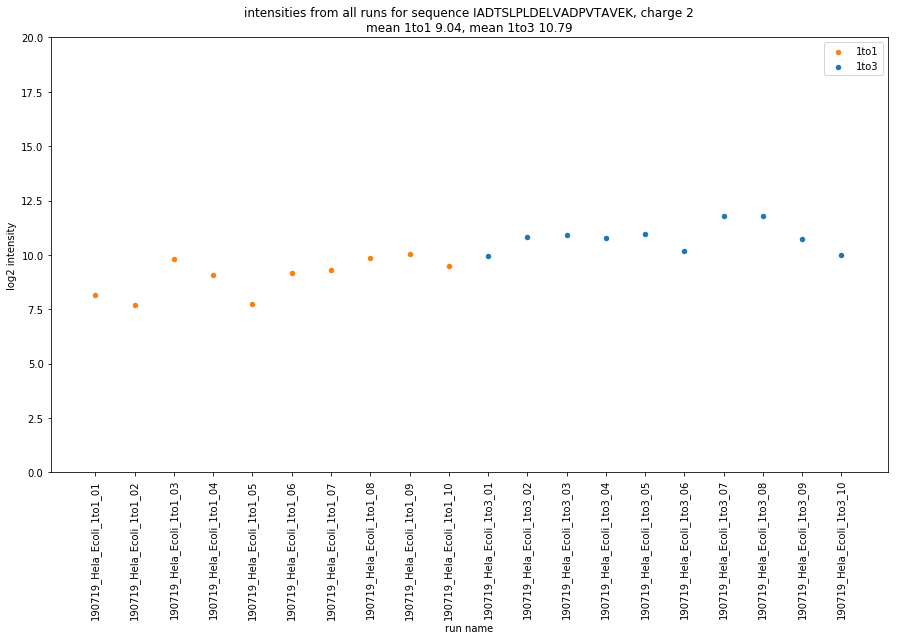

In [12]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)

mean_1to1 = round(np.mean(np.log2(selected_sequence_1to1_df.intensity)), 2)
mean_1to3 = round(np.mean(np.log2(selected_sequence_1to3_df.intensity)), 2)

plt.title('intensities from all runs for sequence {}, charge {}\nmean 1to1 {}, mean 1to3 {}'.format(selected_sequence, selected_sequence_charge, mean_1to1, mean_1to3))

ax1.scatter(selected_sequence_1to1_df.run_name, np.log2(selected_sequence_1to1_df.intensity), marker='o', color='tab:orange', lw=0, s=30, alpha=1.0, label='1to1')
ax1.scatter(selected_sequence_1to3_df.run_name, np.log2(selected_sequence_1to3_df.intensity), marker='o', color='tab:blue', lw=0, s=30, alpha=1.0, label='1to3')

# highlight whether a point was adjusted for saturation
adj_sat_1to1 = selected_sequence_1to1_df[(selected_sequence_1to1_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to1) > 0:
    ax1.plot(adj_sat_1to1.run_name, np.log2(adj_sat_1to1.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

adj_sat_1to3 = selected_sequence_1to3_df[(selected_sequence_1to3_df.isotope_idx_not_in_saturation > 0)]
if len(adj_sat_1to3) > 0:
    ax1.plot(adj_sat_1to3.run_name, np.log2(adj_sat_1to3.intensity), marker='o', markerfacecolor='none', markeredgecolor='springgreen', linestyle='', markeredgewidth=2, ms=15)

# show which isotope was used as a reference
text_style = dict(size=10, color='blue')
for idx,row in adj_sat_1to1.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)
for idx,row in adj_sat_1to3.iterrows():
    ax1.text(row.run_name, np.log2(row.intensity)+1, "ref iso {}".format(int(row.isotope_idx_not_in_saturation)), **text_style, rotation=90)

plt.xlabel('run name')
plt.ylabel('log2 intensity')
plt.legend(loc='best')

# plt.xlim((0,50))
plt.ylim((0,20))
plt.xticks(rotation=90)

plt.show()

#### look at the distribution of intensity deltas for sequences in 1to1 runs 01 and 02

In [13]:
run_A = '190719_Hela_Ecoli_1to1_01'
run_B = '190719_Hela_Ecoli_1to1_02'
sequences_in_run_01_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_A))]
sequences_in_run_02_df = sequences_df[(sequences_df.file_idx == file_idx_for_run(run_B))]

In [14]:
sequences_in_both_runs_df = pd.merge(sequences_in_run_01_df, sequences_in_run_02_df, how='inner', left_on=['sequence','charge'], right_on=['sequence','charge'])


In [15]:
sequences_in_both_runs_df['delta_log_intensity'] = sequences_in_both_runs_df.log_intensity_x - sequences_in_both_runs_df.log_intensity_y

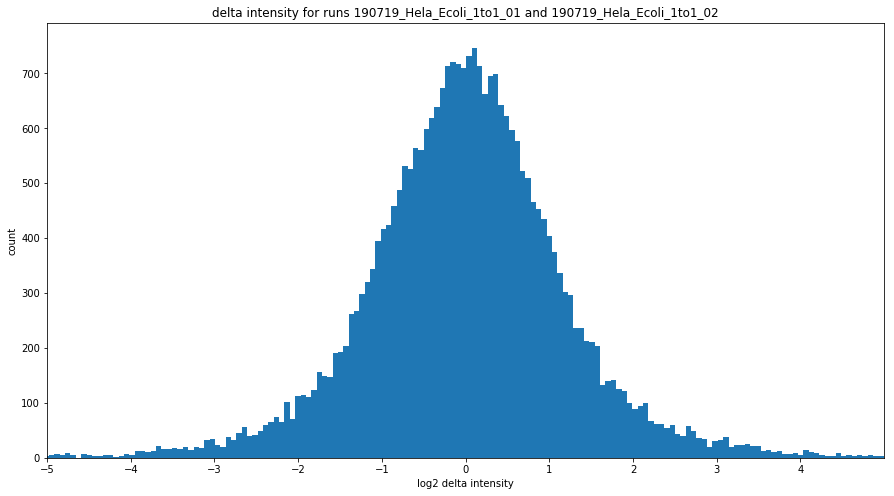

In [22]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(sequences_in_both_runs_df.delta_log_intensity, bins=bins)
plt.xlabel('log2 delta intensity')
plt.ylabel('count')
plt.title('delta intensity for runs {} and {}'.format(run_A, run_B))
ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [23]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_identified >= 15)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_medians_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    batch_1to1_median = group_df[group_df.batch == '1to1'].intensity.median()
    batch_1to3_median = group_df[group_df.batch == '1to3'].intensity.median()
    batch_medians_l.append((group_name[0], group_name[1], batch_1to1_median, batch_1to3_median))
batch_medians_df = pd.DataFrame(batch_medians_l, columns=['sequence','charge','batch_1to1_median','batch_1to3_median'])
batch_medians_df['log_batch_1to1_median'] = np.log2(batch_medians_df.batch_1to1_median)
batch_medians_df['log_batch_1to3_median'] = np.log2(batch_medians_df.batch_1to3_median)
batch_medians_df['delta_log_median'] = batch_medians_df.log_batch_1to3_median - batch_medians_df.log_batch_1to1_median

In [24]:
batch_medians_df.sample(n=5)

,sequence,charge,batch_1to1_median,batch_1to3_median,log_batch_1to1_median,log_batch_1to3_median,delta_log_median
3014,LKDLETQSQDGTFDK,2,4376.5,7847.0,12.095562,12.937925,0.842364
2859,LDADIAHALMSINAVK,3,347.5,381.0,8.440869,8.573647,0.132778
4933,VQGDVAAWFGSLPVVPEGCK,3,357.5,470.0,8.481799,8.876517,0.394718
1221,ELSAEGFNFIGTGVSGGEEGALK,2,4823.0,5064.5,12.235715,12.306204,0.070489
1781,GFTSEITVTSNGK,2,1131.0,767.0,10.143383,9.583083,-0.560300


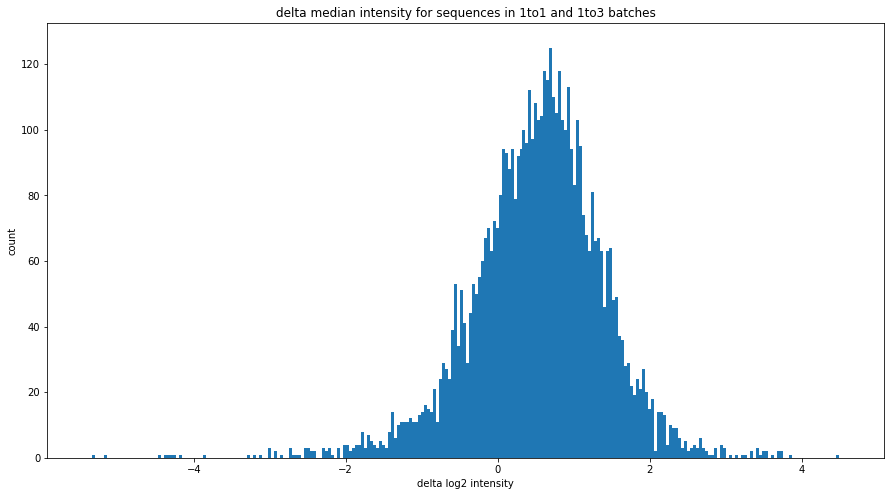

In [25]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_medians_df.delta_log_median, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta median intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()

In [26]:
ecoli_sequences_df = sequences_df[(sequences_df.human == False) & (sequences_df.number_of_runs_identified >= 15)]
# find the median intensity of each sequence in each 1to1 and 1to3 batch
batch_means_l = []
for group_name,group_df in ecoli_sequences_df.groupby(['sequence','charge'], as_index=False):
    batch_1to1_mean = group_df[group_df.batch == '1to1'].intensity.mean()
    batch_1to3_mean = group_df[group_df.batch == '1to3'].intensity.mean()
    batch_means_l.append((group_name[0], group_name[1], batch_1to1_mean, batch_1to3_mean))
batch_means_df = pd.DataFrame(batch_means_l, columns=['sequence','charge','batch_1to1_mean','batch_1to3_mean'])
batch_means_df['log_batch_1to1_mean'] = np.log2(batch_means_df.batch_1to1_mean)
batch_means_df['log_batch_1to3_mean'] = np.log2(batch_means_df.batch_1to3_mean)
batch_means_df['delta_log_mean'] = batch_means_df.log_batch_1to3_mean - batch_means_df.log_batch_1to1_mean

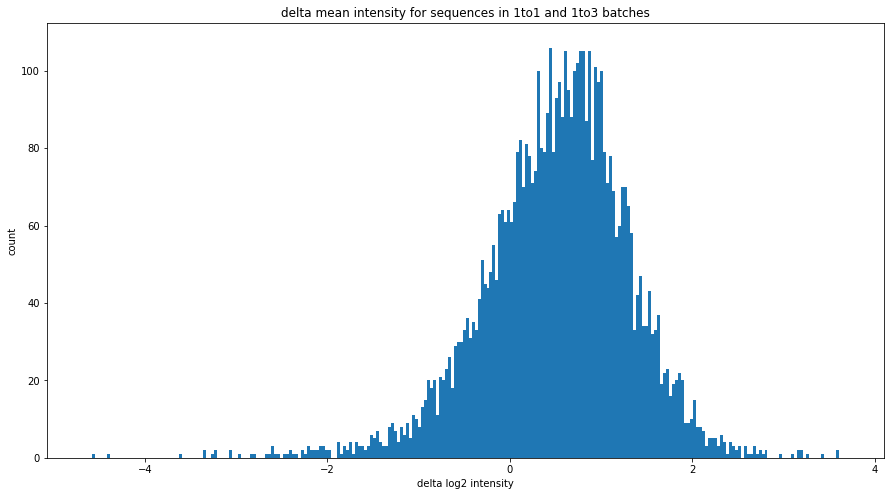

In [27]:
f, ax1 = plt.subplots()
f.set_figheight(8)
f.set_figwidth(15)

plt.margins(0.06)
plt.title('')

bins = 250
hist, bins, _ = plt.hist(batch_means_df.delta_log_mean, bins=bins)
plt.xlabel('delta log2 intensity')
plt.ylabel('count')
plt.title('delta mean intensity for sequences in 1to1 and 1to3 batches')
# ax1.set(xticks=range(-5,5), xlim=[-5, 5])

plt.show()